In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms, datasets
import os
import shutil
import random
import csv
import zipfile
import PIL
import math
from IPython.display import clear_output

In [48]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [49]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [93]:
class LatentSpaceMapper:
    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, batch_size=1, size_z=100, max_opt_iterations=30000, opt_threshold=140.0, plateu_threshold=3.0, plateu_check_every_n_iter=4000, learning_rate=0.4, print_every_n_iters=10000, ignore_rules_below_threshold=50, retry_after_n_iters=10000):
        image.to(self.device)
        z = torch.randn(batch_size, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=learning_rate)
        losses = []
        final_loss = 0
        latest_checkpoint_loss = 0

        scheduler = lr_scheduler.LinearLR(z_optimizer, start_factor=0.4, end_factor=0.001, total_iters=max_opt_iterations-(math.floor(max_opt_iterations*0.2)))
        for i in range(max_opt_iterations):
            retry = False
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            final_loss = loss.data.item()

            if i == 1:
                latest_checkpoint_loss = loss.data.item()

            if loss.data.item() < opt_threshold*batch_size:
                print(f"Iteration: {i} -- Reached Defined Optimum -- Final Loss: {loss.data.item()}")
                break

            if i % print_every_n_iters == 0 or i == max_opt_iterations-1:
                print(f"Iteration: {i} -- Current Loss: {loss.data.item()} -- Current Learning-Rate: {z_optimizer.param_groups[0]['lr']}")
                losses.append(loss.data.item())

            if i % plateu_check_every_n_iter == 0:
                if abs(loss.data.item()-latest_checkpoint_loss) < plateu_threshold:
                    print(f"Reached Plateu at Iteration {i} -- Loss: {loss.data.item()}")
                    retry = True
                    break
                latest_checkpoint_loss = loss.data.item()

            if i == retry_after_n_iters and loss.data.item() > ignore_rules_below_threshold:
                retry = True
                break

            scheduler.step()

        return z, final_loss, retry

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        #_, x_prop = self.discriminator(x_query)
        #_, g_z_prop = self.discriminator(g_z)

        loss_r = torch.sum(torch.abs(x_query - g_z))
        #loss_d = torch.sum(torch.abs(x_prop - g_z_prop))

        # return (1 - lamda) * loss_r + lamda * loss_d
        return loss_r

In [51]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset


class AnoMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoMNIST")
        assert os.path.exists(os.path.join(root_dir, "anomnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "anomnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}


In [52]:
def generate_augmented_mnist_images(base_folder, num, max_augmentation_thickness=5,
                                    randomize_augmentation_thickness=False, labels=[]):
    assert max_augmentation_thickness <= 7, "max_augmentation_thickness must be smaller than 7"
    os.makedirs(base_folder, exist_ok=True)

    dataset = datasets.MNIST(
        root=base_folder,
        train=True,
        download=True,
    )

    if len(labels) > 0:
        dataset = [d for d in dataset if (d[1] in labels)]
    else:
        dataset = dataset.data

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    augmentation_thickness: int = random.randint(1, max_augmentation_thickness)
    for i in range(num):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]

        augmentation_thickness = random.randint(3,
                                                max_augmentation_thickness) if randomize_augmentation_thickness else augmentation_thickness
        random_idx = random.randint(4, 20)
        for j in range(img.size[0]):
            for k in range(augmentation_thickness):
                img.putpixel((j, random_idx + k + 1), 0)

        img.save(os.path.join(ano_mnist_drop_folder, f"img_aug_{label}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_aug_{label}_{i}.png', f"{label}", "True"]
            writer.writerow(fields)


def generate_anomalous_image_files(base_folder, num, labels=[], copy_zip_to=''):
    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly"]
        writer.writerow(fields)

    generate_augmented_mnist_images(base_folder, num=num, labels=labels)
    if copy_zip_to:
      shutil.make_archive(os.path.join(copy_zip_to, "AnoMNIST"), 'zip', ano_mnist_drop_folder)

def get_ano_mnist_dataset(transform, root_dir, labels=[9], train_size=0.9):
    ano_mnist_dataset = AnoMNIST(
        root_dir=root_dir,
        transform=transform
    )

    mnist_dataset = AnomalyExtendedMNIST(
        root=root_dir,
        train=True,
        transform=transform,
        download=True,
    )

    dat = torch.utils.data.ConcatDataset([ano_mnist_dataset, mnist_dataset])

    if len(labels) > 0:
        dat = [d for d in dat if (d[1]['label'] in labels)]

    absolute_train_size = int(len(dat) * train_size)
    absolute_test_size = len(dat) - absolute_train_size
    return torch.utils.data.random_split(dat, [absolute_train_size, absolute_test_size])

In [53]:
def load_ano_mnist_from_drive(drop_folder):
  with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoMNIST.zip', 'r') as zip_ref:
    zip_ref.extractall(drop_folder)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cuda')

In [55]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

# generate_anomalous_image_files(base_folder='/content/data', num=2000, labels=[9]) # number of normals is: 5949
load_ano_mnist_from_drive(drop_folder='/content/data')
ano_mnist_dataset, _ = get_ano_mnist_dataset(transform=transform, root_dir='/content/data', labels=[9])

Iteration: 0 -- Current Loss: 255.9646759033203 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 199.99874877929688 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 233.4507598876953 -- Current Learning-Rate: 0.16000000000000003
Iteration: 2698 -- Reached Defined Optimum -- Final Loss: 44.995582580566406
Original Image


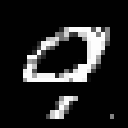

Mapped and Reconstructed Image


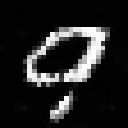

-----------------------
Iteration: 0 -- Current Loss: 195.9923858642578 -- Current Learning-Rate: 0.16000000000000003
Iteration: 5000 -- Current Loss: 47.49833297729492 -- Current Learning-Rate: 0.15002499999997687
Iteration: 9742 -- Reached Defined Optimum -- Final Loss: 44.9998779296875
Original Image


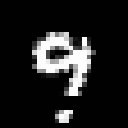

Mapped and Reconstructed Image


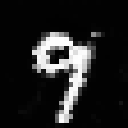

-----------------------
Iteration: 0 -- Current Loss: 190.02554321289062 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 109.72525024414062 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 204.75015258789062 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 192.54653930664062 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 155.2489013671875 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 131.726806640625 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 118.40657043457031 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 258.0911560058594 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 178.0372314453125 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 149.25392150878906 -- Current Learning-Rate: 0.16000000000000003
Iteration: 0 -- Current Loss: 1

KeyboardInterrupt: ignored

In [94]:
def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")

if not os.path.exists(base_folder):
    os.mkdir(base_folder)

if os.path.exists(base_folder):
    shutil.rmtree(base_folder)
    os.mkdir(base_folder)

with open(csv_path, 'a', newline='') as file:
    writer = csv.writer(file)
    fields = ["filename", "label", "anomaly", "reconstruction_loss"]
    writer.writerow(fields)

# Start mapping
only_map_anomalies = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(ano_mnist_dataset)
#for img in ano_mnist_dataset:
i = 0
while i < len(ano_mnist_dataset):

    # print(f"{counter} images left")

    if (ano_mnist_dataset[i][1]["anomaly"] == True and only_map_anomalies) or not only_map_anomalies:
        mapped_z, reconstruction_loss, retry = lsm.map_image_to_point_in_latent_space(ano_mnist_dataset[i][0],
                                                                               batch_size=1,
                                                                               max_opt_iterations=100000,
                                                                               opt_threshold=45.0,
                                                                               plateu_threshold=0.001,
                                                                               plateu_check_every_n_iter=10000,
                                                                               learning_rate=0.4,
                                                                               print_every_n_iters=5000,
                                                                               ignore_rules_below_threshold=50,
                                                                               retry_after_n_iters=3000)

        if retry:
            i-=1
            continue

        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', ano_mnist_dataset[i][1]["label"], ano_mnist_dataset[i][1]["anomaly"], math.floor(reconstruction_loss)]
            writer.writerow(fields)

        torch.save(mapped_z, os.path.join(base_folder, f'mapped_z_{counter}.pt'))
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
          create_cp(counter)
          clear_output

        print('Original Image')
        t(ano_mnist_dataset[i][0]).resize((128, 128), PIL.Image.NEAREST).show()
        original_img = generator(mapped_z).cpu()
        img = t(original_img[0]).resize((128, 128), PIL.Image.NEAREST)
        print('Mapped and Reconstructed Image')
        img.show()
        print('-----------------------')

    i+=1
    counter-=1

create_cp(0)